In [1]:
__author__ = 'Knut Olsen <kolsen@noao.edu>' # single string; emails in <>
__version__ = '20200101' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['smash_dr2']  # enter used datasets by hand
__keywords__ = ['LMC','Healpix map','plot:cmd']

# Exploring SMASH DR2

*Knut Olsen & the NOAO Data Lab Team*

## Table of contents
* [Goals & Summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [Basic info](#basic)
* [Examine the columns of the SMASH DR2 object table](#columns)
* [Make an object density map](#density)
* [Make depth and color maps](#depth)
* [Do a spatial query and make color-color diagrams and CMDs](#cmd)
* [SMASH DR2 File Service](#fileservice)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
* Get an overview of the contents of SMASH DR2
* Learn to make maps of object density, depth, and color
* Learn to plot SMASH DR2 color-magnitude diagrams
* Learn how to use the crossmatch table to clean a CMD using Gaia proper motions

# Summary
The Survey of the Magellanic Stellar History (SMASH) used the Dark Energy Camera (DECam) to map 480 square degrees of sky to depths of ugriz~24th mag with the goal of identifying broadly distributed, low surface brightness stellar populations associated with the stellar halos and tidal debris of the Magellanic Clouds. It contains measurements of approximately 360 million objects distributed in discrete fields spanning an area of about 2400 square degrees. The first data release (DR1) contained ~100 million objects from 61 observed fields, while the second data release (Nidever et al. 2020) contains all 360 million objects in 197 fields. The SMASH overview paper (Nidever et al. 2017) describes the survey in detail, including its goals, survey strategy, reduction, and calibration.

The Data Lab hosts several tables in the smash_dr2 schema: 
* field - Information on each field (197 rows).
* exposure - Information on each exposure (5,982 rows).
* chip - Information on each chip image (359,393 rows).
* source - All of the individual source measurements (4,155,114,664 rows).
* object - Average values for each unique object (360,201,921 rows).
* deep - Same as object but only using the deepest exposures for each field (357,395,383 rows).
* xmatch - Crossmatches between SMASH and Gaia DR2, 2MASS and ALLWISE (4,155,114,664 rows).

In this notebook, we'll use these some of tables to do some exploration of the SMASH survey.


<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php

* SMASH overview paper: Nidever et al. 2017, "SMASH – Survey of the Magellanic Stellar History", AJ, 2017, 154, 199

* SMASH DR2 paper: Nidever et al. 2020, "The Second Data Release of SMASH – Survey of the Magellanic Stellar History", in preparation

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
import numpy as np
import pylab as plt
import matplotlib
import healpy as hp
import pandas as pd
from io import StringIO
from astropy import units as u
from getpass import getpass

%matplotlib inline

# Datalab and related imports
from dl import authClient as ac, queryClient as qc
from dl import storeClient as sc

<a class="anchor" id="auth"></a>
# Authentication
If this is the first time logging in to Data Lab, you can make use of virtual storage and myDB by logging in with your credentials here. You only need to do this once, as your login is kept current as an active user unless you logout or login as a different user.

In [3]:
# Uncomment the next line if not logged in
#token = ac.login(input("Enter user name: "),getpass("Enter password: "))
print(ac.whoAmI())

robertdemo


<a class="anchor" id="basic"></a>
# Basic info
First, let's look at the tables available in the SMASH DR2 database, and then get some basic information from the Data Lab statistics database (<tt>tbl_stat</tt>) about the main SMASH object table, smash_dr2.object. 

In [4]:
try:
    print(qc.schema('smash_dr2',format='json',profile='default'))
except Exception as e:
    print(e.message)


Schema: smash_dr2

      Table Name   Description
      ----------   -----------
            chip   Info on each chip in the frame
            deep   Average photometry of each unique object only from deep ex
                   posures
        exposure   Info on each exposure
           field   Info on each target field (position, Num exposures, etc)
          object   Average photometry of each unique object
          source   All of the individual source measurements
          xmatch   Crossmatch of object against GAIA DR2 and WISE



In [5]:
%%time
query = "SELECT * FROM tbl_stat WHERE schema='smash_dr2' AND tbl_name='object'" # Retrieve useful stats, quickly
try:
    info = qc.query(sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

CPU times: user 28.7 ms, sys: 0 ns, total: 28.7 ms
Wall time: 274 ms


In [6]:
print(info.split('\n')[0]) #header row
print(info.split('\n')[-2]) #(next-to-last line, last line is empty)

schema,tbl_name,nrows,ncols,nindex,table_size,indexes_size,total_size
smash_dr2,object,360191328,42,22,81 GB,153 GB,234 GB


<a class="anchor" id="fields"></a>
# Plot fields
Now, we'll query the smash_dr2.fields table and make a plot of the fields on the sky.

In [7]:
# query DB for a list of all SMASH fields
query = "SELECT * FROM smash_dr2.field"  # define sql query as a string
df_field = qc.query(sql=query,fmt='pandas')  # submit the query, return as Pandas dataframe

In [8]:
df_field

,name,fieldid,ra,dec,glon,glat,mlon,mlat,ring256,nchips,...,nexp_u,nexp_g,nexp_r,nexp_i,nexp_z,ucalib,gcalib,rcalib,icalib,zcalib
0,Field100,100,172.1420,-28.1462,281.530644,31.258570,63.508955,-6.461679,578538,1860,...,6,6,7,6,6,360,360,420,360,360
1,Field101,101,172.5690,-22.8770,279.580108,36.287276,68.689536,-5.296765,545771,1860,...,6,6,7,6,6,360,360,420,360,360
2,Field104,104,175.7920,-39.3373,288.795369,21.653064,53.347265,-12.289558,642036,1860,...,6,6,7,6,6,360,360,420,360,360
3,Field106,106,177.4930,-80.6178,300.327681,-18.058317,10.898055,-18.060186,781228,1860,...,6,6,7,6,6,360,360,420,360,360
4,Field109,109,179.0770,-36.2630,290.665444,25.292117,57.004874,-14.162307,625661,1860,...,6,6,7,6,6,360,360,420,360,360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Field93,93,164.8560,-23.1833,272.006815,32.876216,66.141194,1.335595,547797,2880,...,9,10,11,9,9,540,600,660,540,540
193,Field94,94,166.0920,-36.1762,279.871948,21.855463,54.260951,-4.049729,624600,2940,...,9,14,8,9,9,540,840,480,540,540
194,Field98,98,170.2990,-32.1685,281.569265,26.932493,59.170913,-6.110605,602084,1860,...,6,6,7,6,6,360,360,420,360,360
195,Field99,99,171.0490,-39.8055,285.243563,20.050837,51.960132,-8.865542,645094,1800,...,6,6,6,6,6,360,360,360,360,360


We'll plot the fields on an orthographic projection of the southern sky, using marker size to indicate the number of exposures per field and color to indicate the number of objects within a field.

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/home/robert/miniconda3/envs/py38_dl1/lib/python3.8/site-packages/healpy/projector.py:846: RuntimeWarning: invalid value encountered in greater
  mask = np.asarray(x) ** 2 + np.asarray(y) ** 2 > 1.0
/home/robert/miniconda3/envs/py38_dl1/lib/python3.8/site-packages/healpy/projaxes.py:423: RuntimeWarning: invalid value encountered in greater
  w = np.where(d2 > threshold)[0]


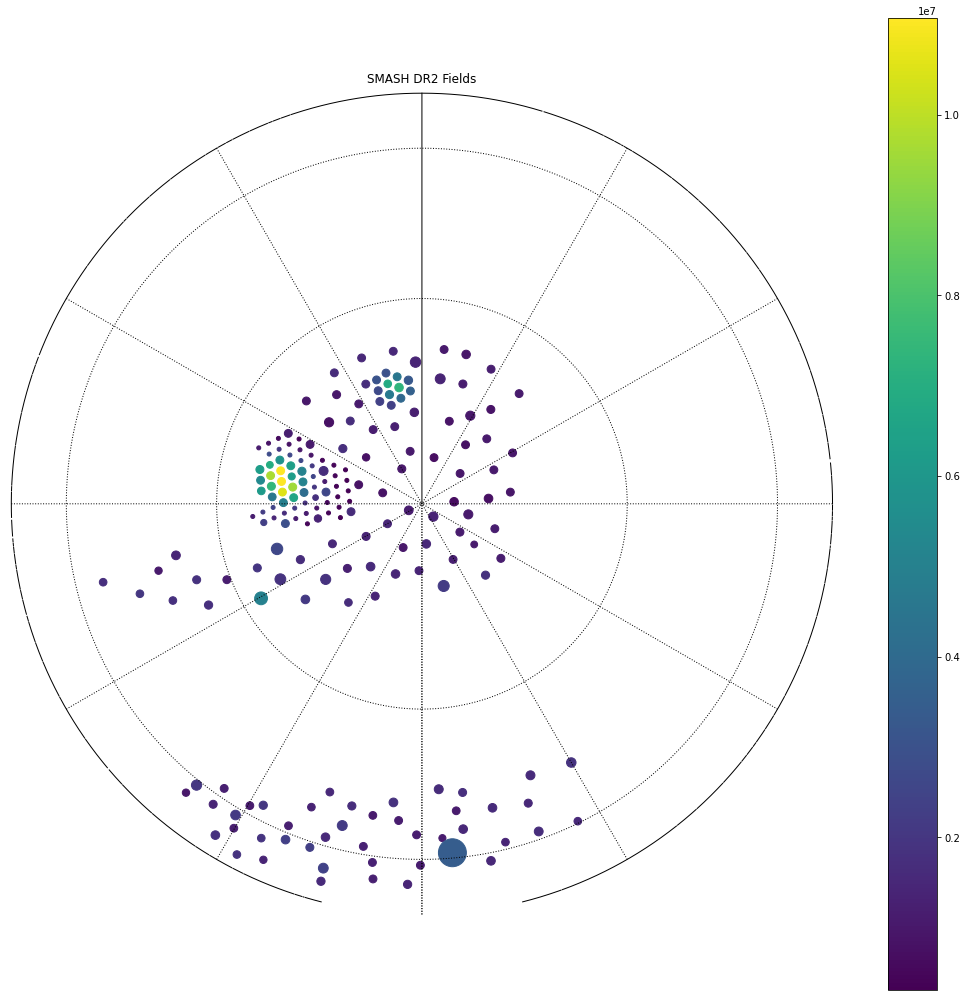

In [9]:
fig=plt.figure(figsize=(15,15))
dummy=np.zeros(hp.nside2npix(2))
hp.orthview(dummy,coord='C',rot=(0,-90,0),half_sky=True,cmap='binary',min=0,max=100,cbar=False,fig=1,title='SMASH DR2 Fields',notext=True)
im = hp.projscatter(df_field['ra'], df_field['dec'], marker='o',s=df_field['nexp'].values*2,c=df_field['nobj'],lonlat=True,cmap='viridis')
plt.colorbar(im)
hp.graticule()

labels = False # set to True if you want to label the points with the field IDs
if labels:
    for ra1,dec1,fid1 in zip(df_field['ra'].values,df_field['dec'].values,df_field['fieldid'].values):
        hp.projtext(ra1, dec1,fid1,coord='C',lonlat=True)

The number of objects in any given field is a function of both surface brightness and of the photometric depth.  The main body fields are very crowded, and so have lots of objects.  Field 169 has lots of objects because many exposures were taken within it.

<a class="anchor" id="columns"></a>
# Examine the columns of the SMASH DR2 object table
Next, we'll take a look at the first 100 rows from smash_dr2.object, and get all columns.  Throughout this notebook, we'll store results as Pandas dataframes.

In [10]:
query = """SELECT *
           FROM smash_dr2.object
           LIMIT 100
        """

In [11]:
%%time
try: # should take <1 sec
    df1 = qc.query(sql=query, fmt='pandas') # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

CPU times: user 44.8 ms, sys: 0 ns, total: 44.8 ms
Wall time: 342 ms


In [12]:
print("Number of rows:", len(df1))
print(df1.columns) # print column headings
print(len(df1.columns))

Number of rows: 100
Index(['id', 'ra', 'dec', 'raerr', 'decerr', 'rascatter', 'decscatter', 'ndet',
       'depthflag', 'umag', 'uerr', 'uscatter', 'ndetu', 'gmag', 'gerr',
       'gscatter', 'ndetg', 'rmag', 'rerr', 'rscatter', 'ndetr', 'imag',
       'ierr', 'iscatter', 'ndeti', 'zmag', 'zerr', 'zscatter', 'ndetz', 'chi',
       'sharp', 'flag', 'prob', 'ebv', 'htm9', 'ring256', 'nest4096', 'glon',
       'glat', 'elon', 'elat', 'random_id'],
      dtype='object')
42


In [13]:
df1

,id,ra,dec,raerr,decerr,rascatter,decscatter,ndet,depthflag,umag,...,prob,ebv,htm9,ring256,nest4096,glon,glat,elon,elat,random_id
0,Field153.1633022,103.068355,-37.973539,0.099110,0.099110,99.990000,99.990000,1,1,NaN,...,99.99,0.148189,2590841,634661,162297226,247.782969,-16.141355,111.190624,-60.455055,-1.488330e-29
1,Field153.1633023,103.071774,-37.973599,0.073320,0.073320,99.990000,99.990000,1,1,NaN,...,99.99,0.148105,2590841,634661,162297224,247.784083,-16.138880,111.196021,-60.454623,-3.278610e+35
2,Field153.1632994,103.071598,-37.972329,0.060229,0.060229,99.990000,99.990000,1,1,99.9900,...,99.99,0.148330,2590841,634661,162297224,247.782804,-16.138531,111.195274,-60.453399,-6.870990e-11
3,Field153.1751465,103.082522,-37.972303,0.401499,0.401499,99.990000,99.990000,1,1,23.2145,...,99.99,0.148101,2590841,634661,162297225,247.786153,-16.130543,111.212433,-60.451802,1.297990e+37
4,Field153.1751475,103.083560,-37.972606,0.236335,0.236335,99.990000,99.990000,1,1,22.6765,...,99.99,0.148025,2590841,634661,162297225,247.786766,-16.129898,111.214178,-60.451950,-9.703800e+36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Field153.1751401,103.107393,-37.970545,0.341630,0.341630,99.990000,99.990000,1,1,23.1245,...,99.99,0.147998,2590841,634661,162297222,247.792141,-16.111717,111.250866,-60.446490,2.539970e+02
96,Field153.1632970,103.109272,-37.971138,0.039559,0.039559,0.012874,0.040775,2,1,20.8003,...,99.99,0.147889,2590841,634661,162297222,247.793294,-16.110568,111.254039,-60.446802,-3.742040e-23
97,Field153.1751492,103.116218,-37.973574,0.274660,0.274660,99.990000,99.990000,1,1,22.9035,...,99.99,0.147484,2590841,634661,162297220,247.797789,-16.106414,111.265857,-60.448195,-7.728790e+00
98,Field153.1632971,103.120233,-37.971245,0.245550,0.245550,99.990000,99.990000,1,1,99.9900,...,99.99,0.147830,2590841,634661,162297221,247.796785,-16.102604,111.271301,-60.445326,-6.575050e+04


We'll use the information in these columns in the sections that follow.

<a class="anchor" id="density"></a>
# Make an object density map
Two of the columns in the SMASH DR2 object table, ring256 and nest4096, contain the Healpix indices (NSIDE=256 and 4096, ring and nested schemes) for the objects' RA and Dec.  Healpix is a handy tesselation of the sky into tiles of equal area.  The Python module healpy has all of the Healpix related functions.

To make maps of aggregate quantities in SMASH, we're going to use the database to return results in a query grouped by Healpix index value.  We can then put the results into arrays, and use healpy's functionality to display the maps.

One way to aggregate data is simply to count the number of rows subject to a constraint, in this case for objects with photometric errors in r-band less than 0.2 mags:

In [14]:
%%time
print(qc.query(sql='SELECT COUNT(ra) FROM smash_dr2.object WHERE rerr<0.2')) # should take ~1 min

count
193340891

CPU times: user 39.6 ms, sys: 0 ns, total: 39.6 ms
Wall time: 1min 20s


By using GROUP BY, we can aggregate in specified bins. In this next query, the GROUP BY clause tells the database to aggregate the results by the values in the nest4096 column, and return the average RA and Dec of objects in those groups, as well as the nest4096 value itself and the count of the number of objects in the group.

In [15]:
query = """SELECT avg(ra) as ra0,avg(dec) as dec0,nest4096,count(nest4096) as nb
           FROM smash_dr2.object
           WHERE rerr<0.2
           GROUP BY nest4096
        """

In [16]:
%%time
# This query should take about 30 sec
try:
    df_density = qc.query(sql=query,fmt='pandas') # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

CPU times: user 5.91 s, sys: 2.23 s, total: 8.14 s
Wall time: 1min 25s


Let's verify that the total number of objects returned is the same as from the COUNT query above:

In [17]:
print(np.sum(df_density['nb'])) # print total counts

193340891


### Making the Healpix map
A Healpix map is simply a one-dimensional array with number of elements set by the NSIDE parameter, which is the number of times the base Healpixels are split.  We can visualize it as a map using the <tt>healpy</tt> library.

In [18]:
hmap = np.zeros(hp.nside2npix(4096))

In [19]:
print(df_density.head())

          ra0       dec0   nest4096  nb
0  178.636895 -37.315032  100712303   2
1  178.675798 -37.316326  100712307   1
2  178.661385 -37.314686  100712312   2
3  178.669353 -37.311539  100712313   9
4  178.650171 -37.308400  100712314  10


### Populating the Healpix map
Now we set the elements of our Healpix map to the number of objects returned by the query, calculate the center of the RA and Dec distribution of the objects, and use healpy's orthview to visualize the output.  We'll use a logarithmic version of the map for the visualization.  We'll also overplot the location of the Galactic plane.  Healpy allows you to mix equatorial (coord='C') and Galactic (coord='G') coordinates.

In [20]:
hmap[df_density['nest4096']]=df_density['nb']

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/home/robert/miniconda3/envs/py38_dl1/lib/python3.8/site-packages/healpy/projector.py:846: RuntimeWarning: invalid value encountered in greater
  mask = np.asarray(x) ** 2 + np.asarray(y) ** 2 > 1.0
/home/robert/miniconda3/envs/py38_dl1/lib/python3.8/site-packages/healpy/projaxes.py:423: RuntimeWarning: invalid value encountered in greater
  w = np.where(d2 > threshold)[0]


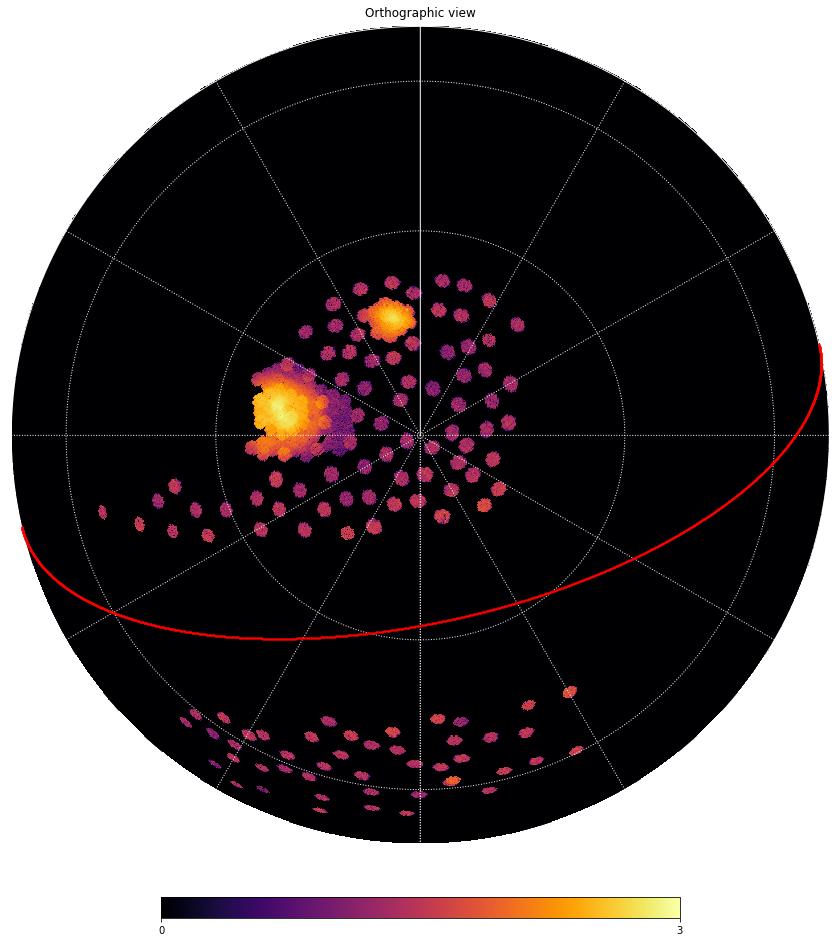

In [21]:
fig = plt.figure(figsize=(15,15))
lon=np.arange(3600)/10
lat=np.zeros(3600)
hp.orthview(np.log10(hmap+1),nest=True,fig=1,rot=(0,-90,0),min=0,max=3,cmap='inferno',coord='C',half_sky=True,norm='linear',notext=True)
hp.graticule(c='w')
foo=hp.projplot(lon,lat,'ro',coord='G',lonlat=True,markersize=1)

In [22]:
print(hp.nside2resol(4096,arcmin=True))

0.8588716029543515


The Healpix map, with NSIDE=4096, has a resolution of 0.86 arcmin per pixel, giving several resolution elements per DECam CCD. We can see this resolution if we zoom into one of the fields.  Field 169 contains the Hydra II dwarf galaxy, discovered by Martin et al. (2015).  You can see Hydra II as an overdensity near the center of the more prominent DECam field outline.

In [23]:
f169 = df_field[df_field['fieldid']==169]

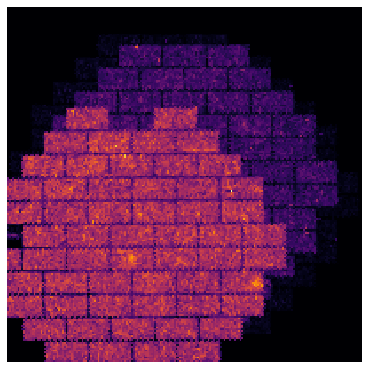

In [24]:
hp.gnomview(hmap,title='',notext=True,cbar=False,reso=0.75,nest=True,rot=(f169['ra'],f169['dec'],0),cmap='inferno',min=0,max=200)


<a class="anchor" id="depth"></a>
# Make depth and color maps
Now we'll get a little fancier with our maps.  We'll have the database return average g- and i-band magnitudes and colors, and make some cuts on the magntude errors.  We again GROUP BY the nest4096 column.


In [25]:
query = """SELECT avg(ra) as ra0,avg(dec) as dec0,nest4096,count(nest4096) as nb,
            avg(gmag) as g,avg(imag) as i,
            avg(gmag-imag) as g_i
           FROM smash_dr2.object
           WHERE gerr<0.2 AND ierr<0.2
           GROUP BY nest4096
          """
print(query)

SELECT avg(ra) as ra0,avg(dec) as dec0,nest4096,count(nest4096) as nb,
            avg(gmag) as g,avg(imag) as i,
            avg(gmag-imag) as g_i
           FROM smash_dr2.object
           WHERE gerr<0.2 AND ierr<0.2
           GROUP BY nest4096
          


In [26]:
%%time
# Query will take ~45 seconds
try:
    df_map = qc.query(sql=query,fmt='pandas') # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

CPU times: user 9.79 s, sys: 3.51 s, total: 13.3 s
Wall time: 1min 38s


In [27]:
print(df_map.head())

          ra0       dec0   nest4096  nb          g          i       g_i
0  178.632900 -37.315792  100712303   1  23.217781  21.083721  2.134060
1  178.661385 -37.314686  100712312   2  22.351546  21.175097  1.176450
2  178.669545 -37.311967  100712313   7  20.519009  19.167673  1.351337
3  178.647937 -37.309070  100712314   4  20.594522  18.560374  2.034148
4  178.656218 -37.293570  100712315   2  22.286801  19.531883  2.754918


### Healpix map of average g magnitude
The map of the average g-band magnitude gives a good idea of how the SMASH DR2 catalog depth varies with position on the sky.  The depth is much shallower in the MC main bodies, which are very crowded.  Fields with less exposure time have fewer objects in them.

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/home/robert/miniconda3/envs/py38_dl1/lib/python3.8/site-packages/healpy/projector.py:846: RuntimeWarning: invalid value encountered in greater
  mask = np.asarray(x) ** 2 + np.asarray(y) ** 2 > 1.0
/home/robert/miniconda3/envs/py38_dl1/lib/python3.8/site-packages/healpy/projaxes.py:423: RuntimeWarning: invalid value encountered in greater
  w = np.where(d2 > threshold)[0]


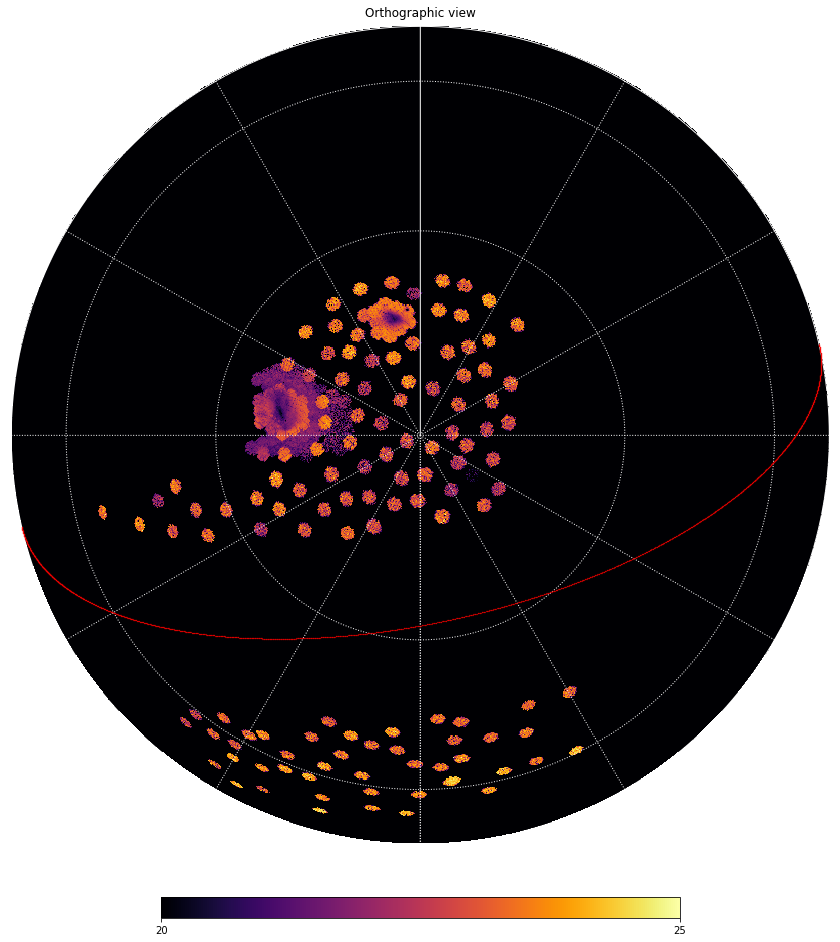

In [28]:
gmap = np.zeros(hp.nside2npix(4096))
gmap[df_map['nest4096']] = df_map['g']

fig = plt.figure(figsize=(15,15))
hp.orthview(gmap,nest=True,fig=1,rot=(0,-90,0),min=20,max=25,cmap='inferno',coord='C',half_sky=True,notext=True)
hp.graticule(c='w')
foo=hp.projplot(lon,lat,'r.',lonlat=True,coord='G',markersize=0.5)



We'll zoom into an area near the SMC and 47 Tuc to see the map in higher resolution.  Crowded regions have shallower photometric depth, as do the areas covered only by short exposures.

In [29]:
f4 = df_field[df_field['fieldid']==4]

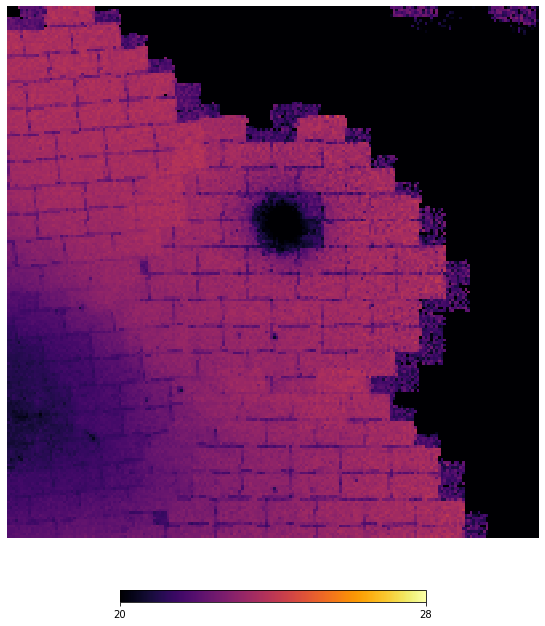

In [30]:
fig = plt.figure(figsize=(10,10))
hp.gnomview(gmap,title='',notext=True,cbar=True,reso=1,nest=True,rot=(f4['ra'],f4['dec'],0),
            cmap='inferno',min=20,max=28,fig=1)



### Healpix map of average g-i color
The map of average color reveals both population differences and the dust lanes in the Clouds, as well as a trend of higher reddening towards the Galactic plane.

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


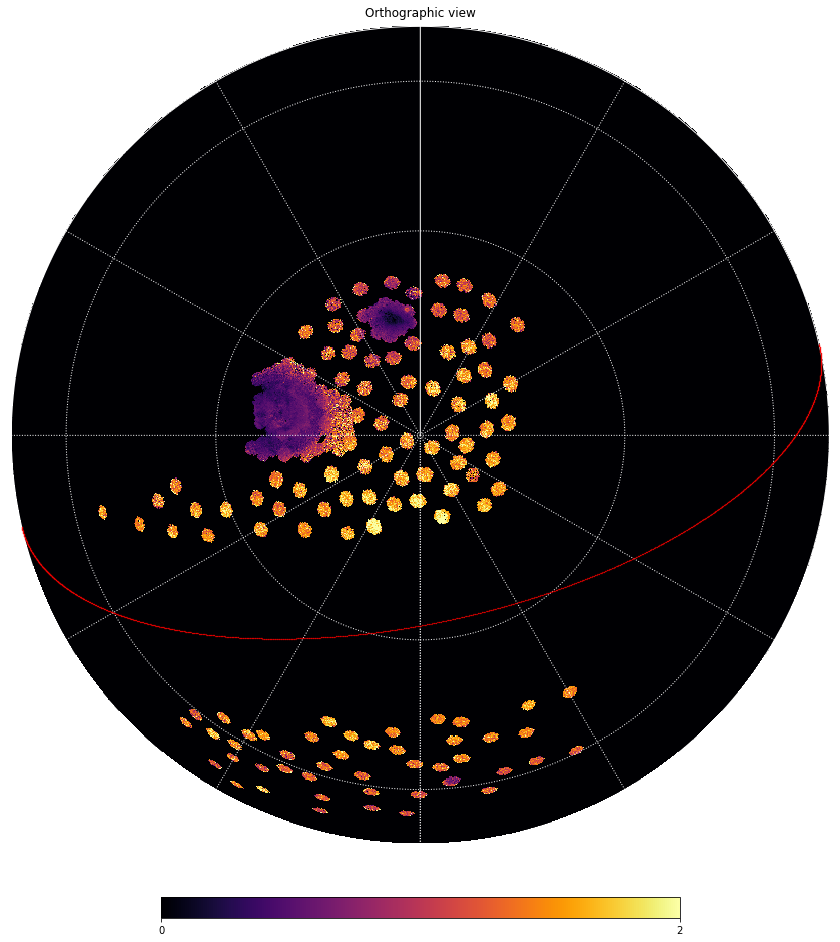

In [31]:
gimap = np.zeros(hp.nside2npix(4096))
gimap[df_map['nest4096']] = df_map['g_i']

fig = plt.figure(figsize=(15,15))
hp.orthview(gimap,nest=True,fig=1,rot=(0,-90,0),min=0,max=2,cmap='inferno',coord='C',half_sky=True,notext=True)
hp.graticule(c='w')
foo=hp.projplot(lon,lat,'r.',lonlat=True,coord='G',markersize=0.5)




Zooming into the region containing the SMC and 47 Tuc shows how the SMC population is bluer than that of 47 Tuc, and that there are prominent dust lanes in the SMC.

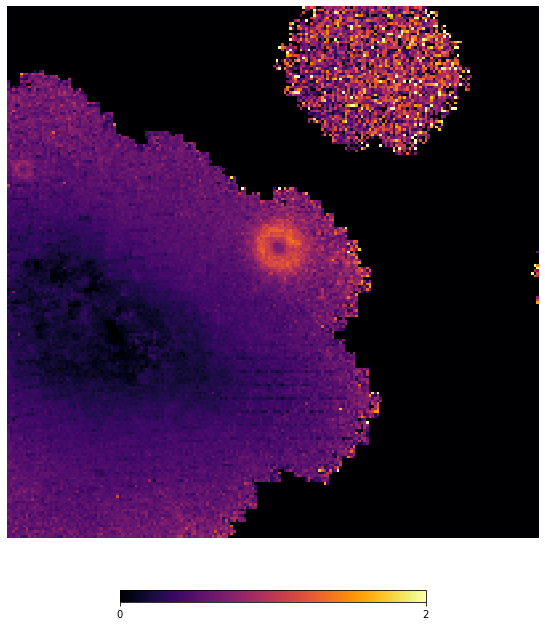

In [32]:
fig = plt.figure(figsize=(10,10))
hp.gnomview(gimap,title='',notext=True,cbar=True,reso=2,nest=True,rot=(f4['ra'],f4['dec'],0),
            cmap='inferno',min=0,max=2,fig=1)



<a class="anchor" id="cmd"></a>
# Do a spatial query and make color-color diagrams and CMDs
Now let's do a cone search for objects within a radius of a particular position.  The SMASH tables are spatially indexed to make such queries fast.  We'll search within a 1 degree radius of Field 4 covering 47 Tuc and part of the SMC.

In [33]:
query = """SELECT *
           FROM smash_dr2.object 
           WHERE q3c_radial_query(ra,dec,{0},{1},{2})
           AND gerr<0.2 AND ierr<0.2 AND rerr<0.2
        """.format(f4['ra'].iloc[0],f4['dec'].iloc[0],1.)
print(query)

SELECT *
           FROM smash_dr2.object 
           WHERE q3c_radial_query(ra,dec,6.23604,-72.3856,1.0)
           AND gerr<0.2 AND ierr<0.2 AND rerr<0.2
        


In [34]:
%%time
try:
    df_cmd = qc.query(sql=query,fmt='pandas') # will take about a minute
except Exception as e:
    print(e.message)

CPU times: user 33.1 s, sys: 9.78 s, total: 42.9 s
Wall time: 4min 12s


In [35]:
df_cmd

,id,ra,dec,raerr,decerr,rascatter,decscatter,ndet,depthflag,umag,...,prob,ebv,htm9,ring256,nest4096,glon,glat,elon,elat,random_id
0,48049.293910,5.965799,-73.382138,0.038758,0.038758,0.003443,0.009371,14,2,24.2677,...,0.91,0.035321,2174685,769694,136459394,305.648820,-43.600353,308.790328,-62.997348,1.310700e-32
1,48049.287901,5.960401,-73.382220,0.099334,0.099334,0.009282,0.043640,15,3,24.9609,...,0.49,0.035283,2174685,769694,136459394,305.650911,-43.600044,308.788503,-62.996043,6.547720e+23
2,48049.272706,5.952823,-73.381367,0.062019,0.062019,0.003088,0.009010,15,2,24.8281,...,0.48,0.035239,2174685,770057,136458717,305.654045,-43.600568,308.787797,-62.993736,-8.035920e+34
3,48049.280423,5.953689,-73.380594,0.030499,0.030499,0.009669,0.023730,17,3,24.2590,...,0.96,0.035252,2174685,770057,136458717,305.653865,-43.601369,308.789548,-62.993573,1.134250e-35
4,48049.293940,5.956474,-73.380910,0.024650,0.024650,0.007483,0.009035,16,3,24.0180,...,0.89,0.035268,2174685,770057,136458717,305.652712,-43.601174,308.789802,-62.994422,2.392330e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1922785,48049.959500,4.430834,-73.225519,0.061800,0.061800,0.005225,0.004159,14,2,24.9505,...,0.84,0.033586,2174509,769692,136460522,306.285419,-43.682531,308.604244,-62.537200,9.796340e-33
1922786,48049.958200,4.439988,-73.230269,0.011997,0.011997,0.048321,0.038265,23,3,23.0880,...,0.79,0.033212,2174509,769692,136460520,306.280642,-43.678335,308.598308,-62.541896,2.671210e+34
1922787,48049.958300,4.446213,-73.230070,0.006082,0.006082,0.020013,0.032707,30,3,21.5943,...,0.90,0.033175,2174509,769692,136460520,306.278249,-43.678854,308.600666,-62.543339,-8.082000e-35
1922788,48049.958410,4.441529,-73.229737,0.051065,0.051065,0.018495,0.025307,15,3,24.5127,...,0.76,0.033235,2174509,769692,136460520,306.280170,-43.678939,308.599793,-62.542007,-1.221200e+02


### Make color-color and CMD plots
We'll show the g-i,g-r color-color diagram, and a color-magnitude diagram.  Notice the CMD of the SMC superimposed by the 47 Tuc CMD.

(26.0, 16.0)

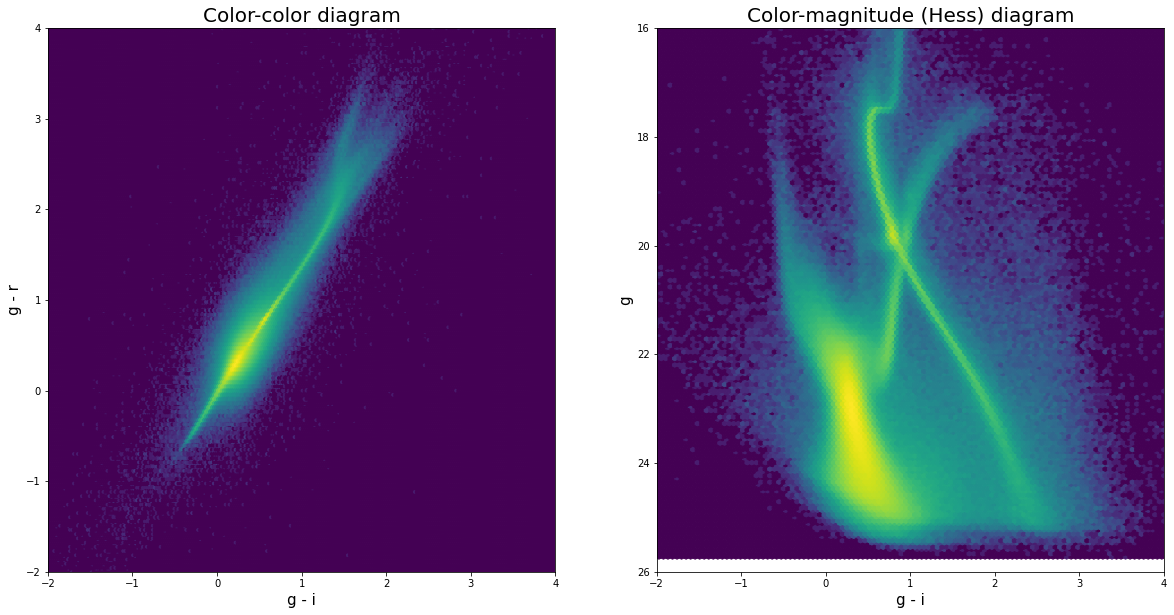

In [36]:
# make a figure
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# color-magnitude diagram (Hess diagram)
im = ax1.hexbin(df_cmd['gmag']-df_cmd['rmag'],df_cmd['gmag']-df_cmd['imag'], \
                gridsize=400,cmap=matplotlib.cm.viridis,norm=matplotlib.colors.LogNorm())
ax1.set_ylabel('g - r',fontsize=15)
ax1.set_xlabel('g - i',fontsize=15)
ax1.set_title('Color-color diagram',fontsize=20)
ax1.set_ylim(-2,4)
ax1.set_xlim(-2,4)


# color-magnitude diagram (Hess diagram)
im2 = ax2.hexbin(df_cmd['gmag']-df_cmd['imag'],df_cmd['gmag'], \
                 gridsize=200,cmap=matplotlib.cm.viridis,norm=matplotlib.colors.LogNorm())
ax2.set_xlabel('g - i',fontsize=15)
ax2.set_ylabel('g',fontsize=15)
ax2.set_title('Color-magnitude (Hess) diagram',fontsize=20)
ax2.set_xlim(-2,4)
ax2.set_ylim(26,16)

### Use the Gaia crossmatch table to isolate 47 Tuc stars
The smash_dr2.xmatch table contains crossmatches of SMASH sources with a number of other surveys, including Gaia DR2.  In the query below, we use a LEFT JOIN to add Gaia proper motion information where available.

In [37]:
query = """SELECT s.id,s.ra,s.dec,s.gmag,s.rmag,s.imag,g.gaia_pmra,g.gaia_pmdec
           FROM smash_dr2.object AS s
           LEFT JOIN (SELECT id,gaia_pmra,gaia_pmdec FROM smash_dr2.xmatch 
               WHERE q3c_radial_query(gaia_ra,gaia_dec,{0},{1},{2})) AS g
           ON s.id = g.id
           WHERE s.gerr<0.2 AND s.ierr<0.2 AND s.rerr<0.2
           AND q3c_radial_query(s.ra,s.dec,{0},{1},{2})
        """.format(f4['ra'].iloc[0],f4['dec'].iloc[0],1.0)
print(query)

SELECT s.id,s.ra,s.dec,s.gmag,s.rmag,s.imag,g.gaia_pmra,g.gaia_pmdec
           FROM smash_dr2.object AS s
           LEFT JOIN (SELECT id,gaia_pmra,gaia_pmdec FROM smash_dr2.xmatch 
               WHERE q3c_radial_query(gaia_ra,gaia_dec,6.23604,-72.3856,1.0)) AS g
           ON s.id = g.id
           WHERE s.gerr<0.2 AND s.ierr<0.2 AND s.rerr<0.2
           AND q3c_radial_query(s.ra,s.dec,6.23604,-72.3856,1.0)
        


In [38]:
%%time
try:
    df_cmd2 = qc.query(sql=query,fmt='pandas') # will take about a minute
except Exception as e:
    print(e.message)

CPU times: user 4.43 s, sys: 1.48 s, total: 5.91 s
Wall time: 42.7 s


In [39]:
df_cmd2

,id,ra,dec,gmag,rmag,imag,gaia_pmra,gaia_pmdec
0,48049.894310,4.448282,-73.232505,23.0558,23.0930,23.1018,NaN,NaN
1,48049.287901,5.960401,-73.382220,24.4288,23.9534,23.2612,NaN,NaN
2,48049.272706,5.952823,-73.381367,24.3682,24.0404,24.2186,NaN,NaN
3,48049.280423,5.953689,-73.380594,23.4313,23.1916,23.0829,NaN,NaN
4,48049.293940,5.956474,-73.380910,23.3360,23.0189,22.8175,NaN,NaN
...,...,...,...,...,...,...,...,...
1922785,48050.366659,8.836789,-73.015249,24.4730,24.1381,23.9907,NaN,NaN
1922786,48050.368070,8.842059,-73.017410,23.1625,22.8988,22.6839,NaN,NaN
1922787,48050.367934,8.842388,-73.016648,24.0568,23.5427,23.2845,NaN,NaN
1922788,48050.374212,8.844786,-73.016675,23.2254,22.9801,22.9402,NaN,NaN


In [40]:
pm = np.sqrt(df_cmd2['gaia_pmra']**2 + df_cmd2['gaia_pmdec']**2)
df_cmdc = df_cmd2[pm>4] # isolate objects with proper motion greater than 4 mas yr^-1

(26.0, 16.0)

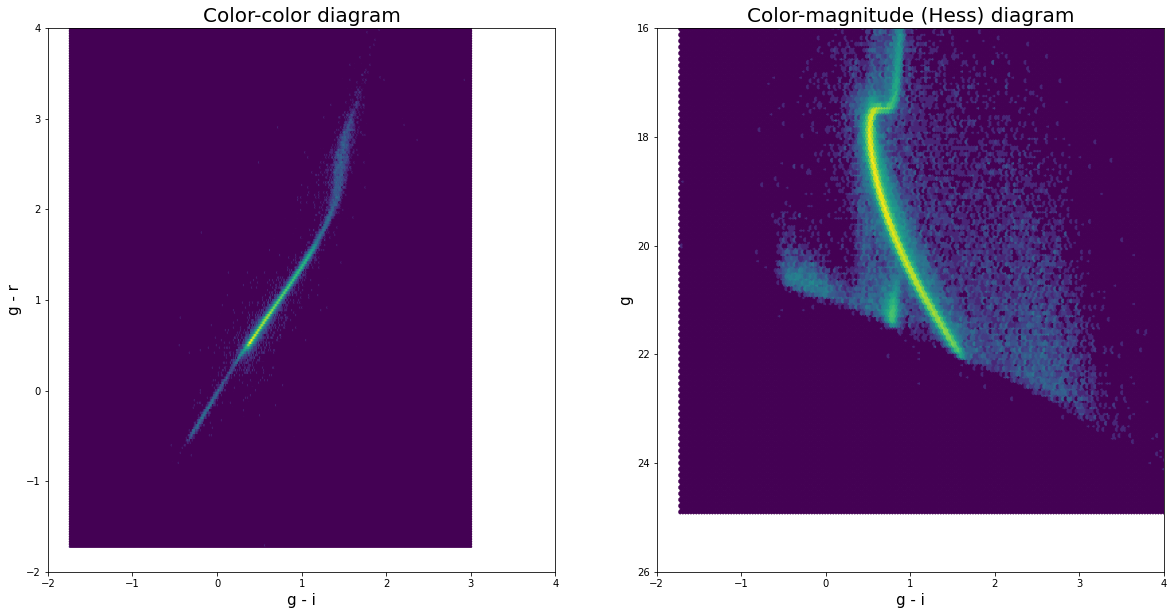

In [41]:
# make a figure
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# color-magnitude diagram (Hess diagram)
im = ax1.hexbin(df_cmdc['gmag']-df_cmdc['rmag'],df_cmdc['gmag']-df_cmdc['imag'], \
                gridsize=400,cmap=matplotlib.cm.viridis,norm=matplotlib.colors.LogNorm())
ax1.set_ylabel('g - r',fontsize=15)
ax1.set_xlabel('g - i',fontsize=15)
ax1.set_title('Color-color diagram',fontsize=20)
ax1.set_ylim(-2,4)
ax1.set_xlim(-2,4)


# color-magnitude diagram (Hess diagram)
im2 = ax2.hexbin(df_cmdc['gmag']-df_cmdc['imag'],df_cmdc['gmag'], \
                 gridsize=200,cmap=matplotlib.cm.viridis,norm=matplotlib.colors.LogNorm())
ax2.set_xlabel('g - i',fontsize=15)
ax2.set_ylabel('g',fontsize=15)
ax2.set_title('Color-magnitude (Hess) diagram',fontsize=20)
ax2.set_xlim(-2,4)
ax2.set_ylim(26,16)

The color-color diagram and CMD of the objects with high proper motion isolate the 47 Tuc sequence.

<a class="anchor" id="fileservice"></a>
# SMASH DR2 File Service
If you don't want to work with the database, you can use the SMASH DR2 file service to access all of the files from the data release.  In this section, we'll give a few examples of how to do this.

You access the file service using the Datalab storeClient. sc.ls() gives a listing of the contents of the service:

In [42]:
sc.ls('smash_dr2://')

'catalogs,instcal,photred,raw,resampled,stacked'

The output is a CSV-formatted string, which we can convert to a Pandas dataframe:

In [43]:
catlist = sc.ls('smash_dr2://catalogs')

In [44]:
catlist[0:100]

'46516_allobj.fits.gz,46516_allobj_bright.fits,46516_allobj_deep.fits.gz,46516_allobj_xmatch.fits.gz,'

In [45]:
dfcat = pd.DataFrame(catlist.split(','),columns=['file'])

In [46]:
dfcat

,file
0,46516_allobj.fits.gz
1,46516_allobj_bright.fits
2,46516_allobj_deep.fits.gz
3,46516_allobj_xmatch.fits.gz
4,46516_allsrc.fits.gz
...,...
4117,Field9_exposures.fits.gz
4118,LMC_mainbody_fields.txt
4119,README.txt
4120,SMC_mainbody_fields.txt


We can use the dataframe to look for files containing a particular field ID, e.g.:

In [47]:
obj = dfcat[dfcat['file'].str.contains('46659')]

In [48]:
obj

,file
16,46659_allobj.fits.gz
17,46659_allobj_bright.fits
18,46659_allobj_deep.fits.gz
19,46659_allobj_xmatch.fits.gz
20,46659_allsrc.fits.gz
21,46659_chips.fits.gz
22,46659_expmap.fits.gz
23,46659_exposures.fits.gz


The storeClient.get() function retrieves data into memory.  We can e.g. readthe contents of the catalog README file.

In [49]:
readme = sc.get('smash_dr2://catalogs/README.txt')

In [50]:
print(readme)

These are the SMASH calibrated catalogs for the 197 fields of DR2.
The overlapping fields in the LMC and SMC main bodies were also combined using 320 HEALPix regions.
LMC_mainbody_fields.txt lists the 68 overlapping LMC fields, and SMC_mainbody_fields.txt lists the
13 overlapping SMC fields.


There are eight FITS binary catalogs per field and HEALPix:
FIELD_exposures.fits.gz         information on each exposure
FIELD_chips.fits.gz             information on each chip
FIELD_allsrc.fits.gz            all of the individual source measurements for this field
FIELD_allobj.fits.gz            average values for each unique object
FIELD_allobj_deep.fits.gz       average values for each unique object using only the deepest exposures
FIELD_allobj_bright.fits        Bright stars from allobj used for cross-matching between fields
FIELD_allobj_xmatch.fits.gz     Crossmatches between SMASH and GAIA, 2MASS and ALLWISE.
FIELD_expmap.fits.gz            The "exposure" map per band.

More information on

<a class="anchor" id="resources"></a>
# Resources and references



Nidever, D.L. et al. (2017, AJ, 154, 199), "SMASH: Survey of the MAgellanic Stellar History"
https://ui.adsabs.harvard.edu/abs/2017AJ....154..199N/abstract

Martin, N.F. et al. (2015, ApJL, 804, 5), "Hydra II: A Faint and Compact Milky Way Dwarf Galaxy Found in the Survey of the Magellanic Stellar History"
https://ui.adsabs.harvard.edu/abs/2015ApJ...804L...5M/abstract